In [34]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from customDataLoader import AnimalImageDataset

current_dir = os.getcwd()
data_dir = os.path.join(os.path.dirname(current_dir), 'data')

train_data_path = os.path.join(data_dir, 'train')
test_data_path = os.path.join(data_dir, 'test')
                               
transform = T.Compose([
    T.Resize((64, 64)),  
    T.ToTensor(), # 마지막에 둬야함
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]) 

train_dataset = AnimalImageDataset(train_data_path, transform=transform)
test_dataset = AnimalImageDataset(test_data_path, is_test=True, transform=transform)

train_data = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_data = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, drop_last=True)

In [2]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16) 
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_data:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/1], Loss: 0.5708


In [30]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    """이미지를 시각화하는 함수"""
    img = img / 2 + 0.5  # 정규화된 이미지를 원래 범위로 변환
    npimg = img.numpy()
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualize_predictions(images, labels, predictions, num_images=10):
    """모델의 예측과 실제 레이블을 시각화하는 함수"""
    plt.figure(figsize=(20, 20))  # figsize를 더 크게 설정하여 이미지 크기 조정
    num_rows = (num_images + 4) // 5  # 이미지가 5개 열로 배치될 수 있도록 행 계산
    for i in range(min(num_images, len(images))):
        plt.subplot(num_rows, 5, i + 1)  # 5열로 서브플롯 배치
        imshow(images[i])
        plt.title(f"Pred: {'Cat' if predictions[i] == 0 else 'Dog'}",
                 fontsize=34)
        plt.axis('off')
    plt.tight_layout(pad=2.0)
    plt.show()

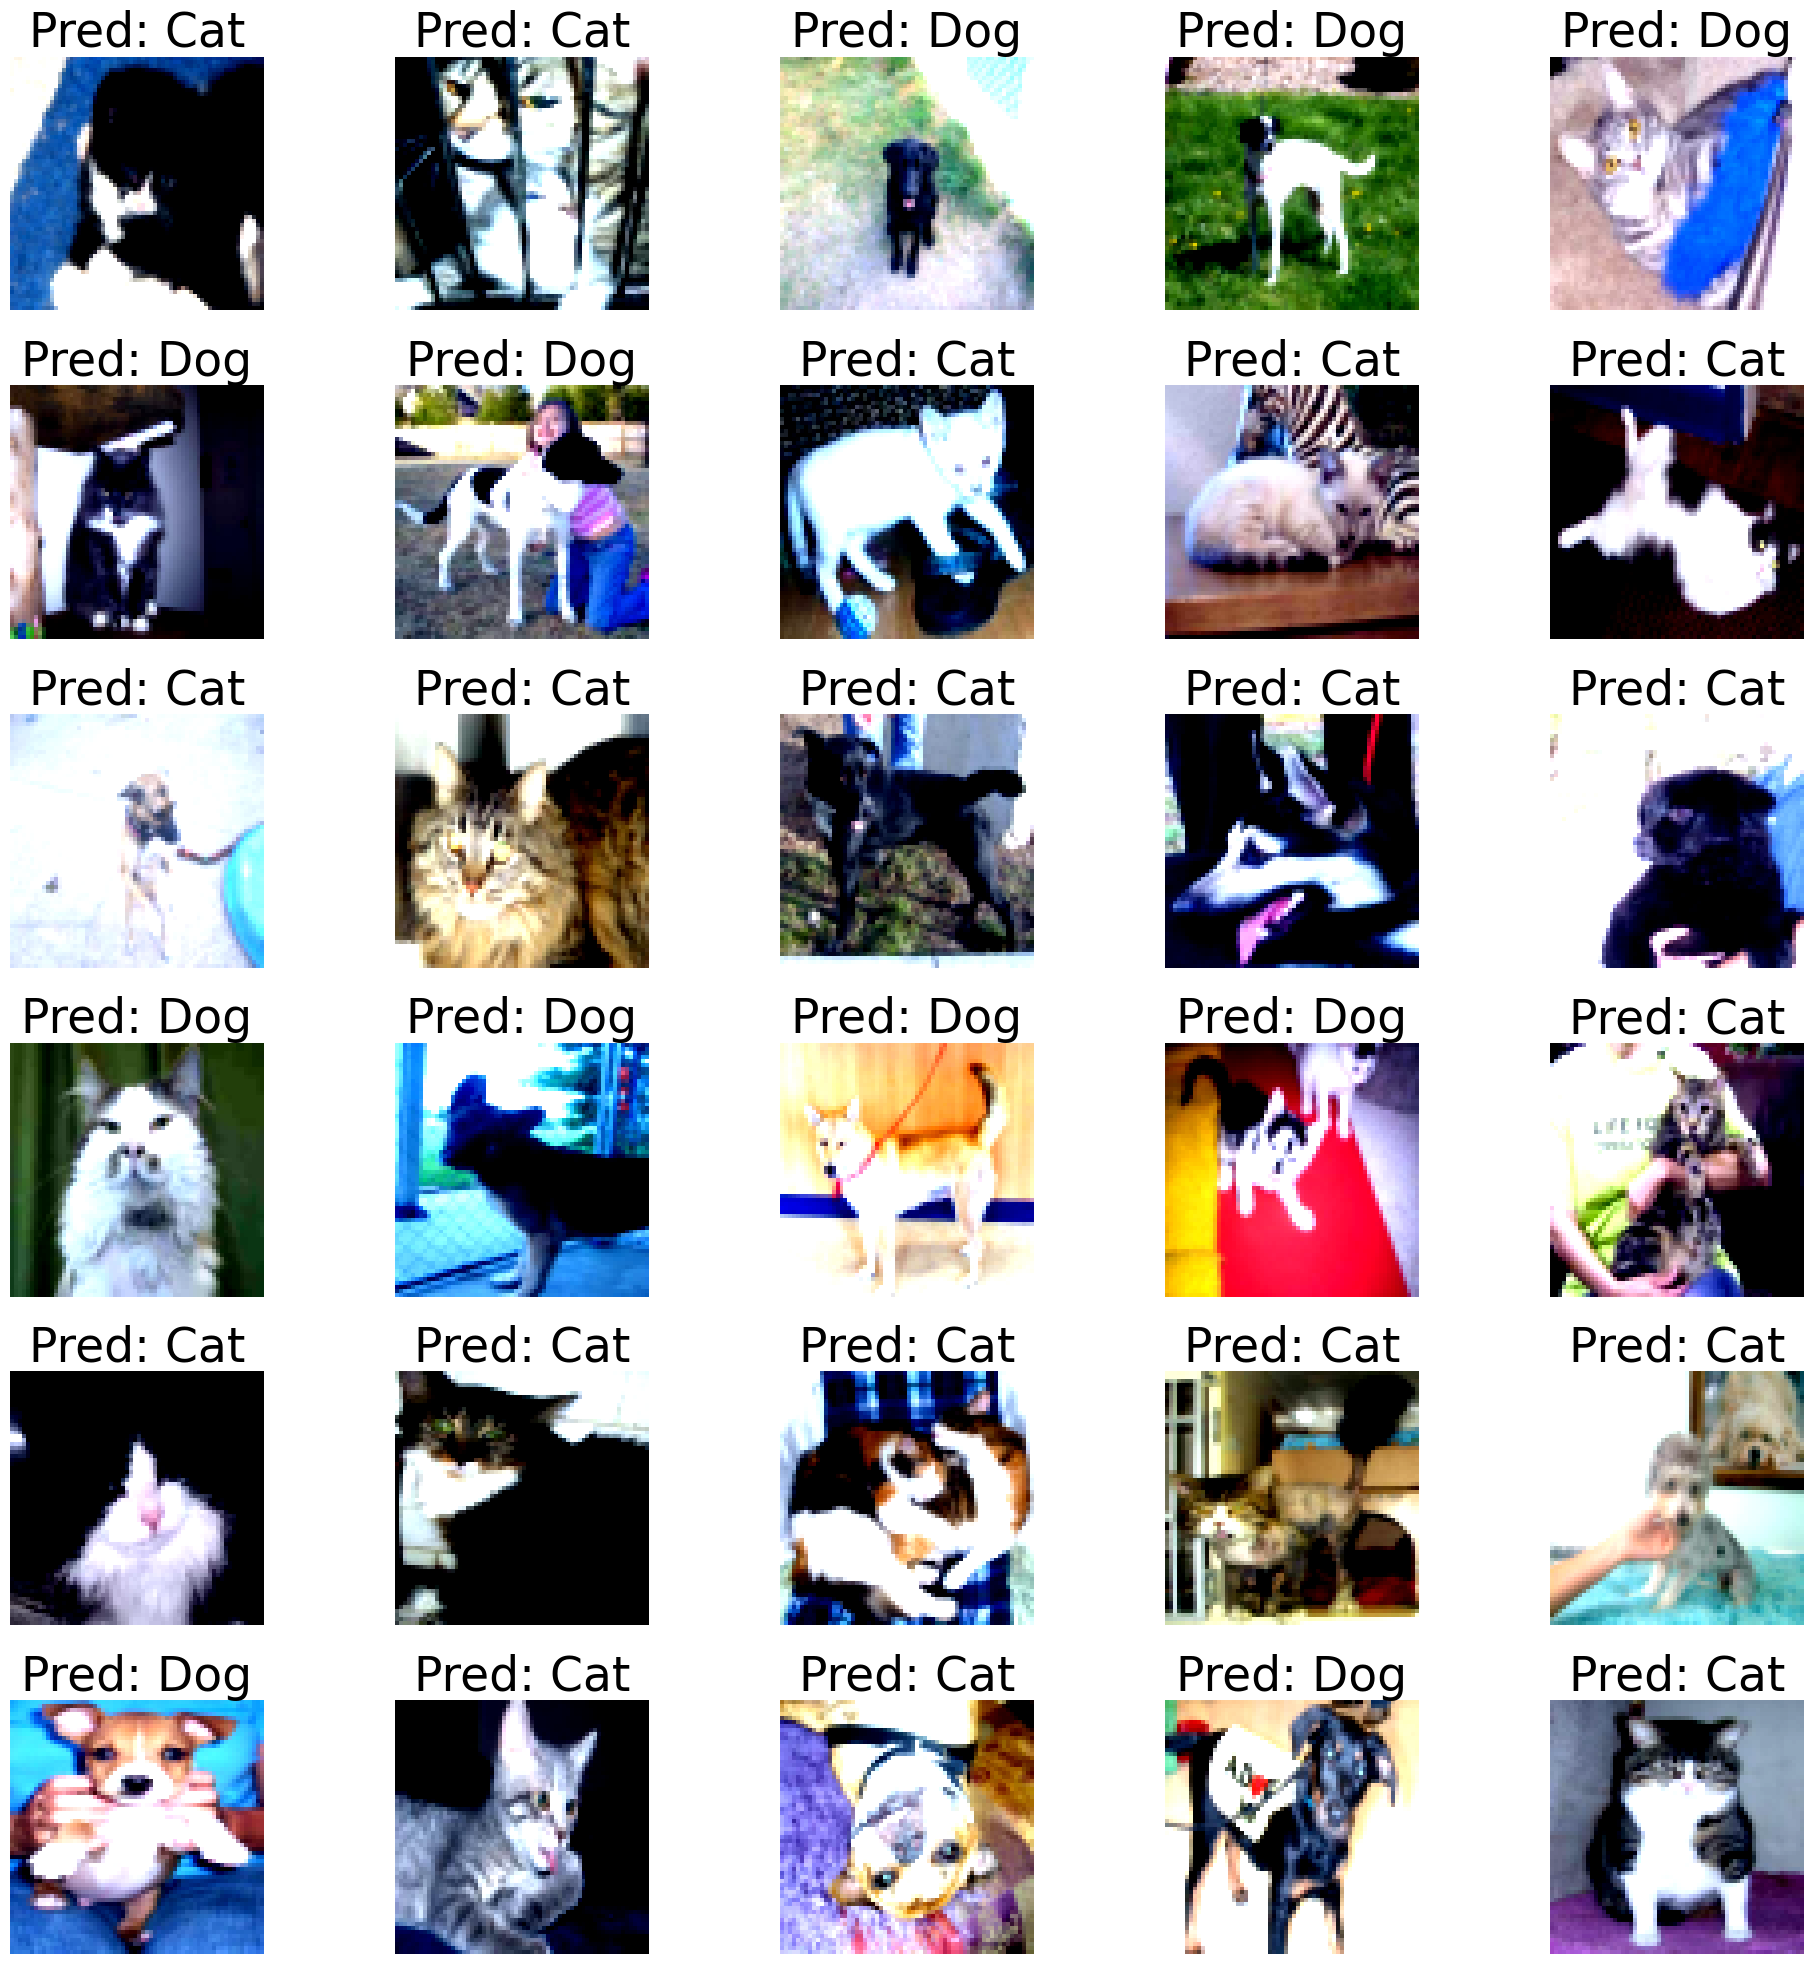

In [33]:
import torch

model.eval()
correct = 0
total = 0

# 저장할 리스트 초기화
sample_images = []
sample_labels = []
sample_predictions = []

with torch.no_grad():
    for images, labels in test_data:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 이미지와 레이블을 리스트에 저장
        sample_images.extend(images.cpu())
        sample_labels.extend(labels.cpu().tolist())
        sample_predictions.extend(predicted.cpu().tolist())

        # num_images만큼 평가 후 중단
        if len(sample_images) >= 30:
            break

# 시각화
visualize_predictions(sample_images, sample_labels, sample_predictions, num_images=30)